In [1]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [ ]:
import itertools
import os
from pathlib import Path

OUT = Path(os.getenv("AGMM_OUT", "out"))
OUT.mkdir(parents=True, exist_ok=True)

# autosave every figure on plt.show()
_plot_counter = itertools.count(1)
__orig_show = plt.show


def _autosave_show(*args, **kwargs):
    idx = next(_plot_counter)
    fname = OUT / f"fig_{idx:02d}.png"
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    return __orig_show(*args, **kwargs)


plt.show = _autosave_show

In [ ]:
from autogmm import AutoGMM, KernelAutoGMM

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import default_converter, pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector, StrVector

# Activate pandas ↔ R conversion
pandas2ri.activate()

# Load mclust
mclust = importr("mclust")

# Pre‑create the default modelNames vector
MODELNAMES_VVV = StrVector(["VVV", "EEE", "VVI", "VII"])


def run_mclust(
    X: pd.DataFrame,
    constrain_cov: bool = True,
    n_components: int | list[int] | range | None = None,
    y_true: np.ndarray | None = None,
):
    # ensure DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # convert to R data.frame
    with localconverter(default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(X)

    # build kwargs for Mclust
    kwargs: dict[str, ro.Vector] = {}
    if constrain_cov:
        kwargs["modelNames"] = MODELNAMES_VVV
    # handle n_components
    if n_components is not None:
        if isinstance(n_components, (list, range, np.ndarray)):
            # convert each to int
            G = [int(g) for g in n_components]
        else:
            G = [int(n_components)]
        kwargs["G"] = IntVector(G)
    # turn of progress bar
    kwargs["verbose"] = False

    # run Mclust
    start = time.perf_counter()
    res = mclust.Mclust(r_df, **kwargs)
    runtime = time.perf_counter() - start

    # extract outputs
    labels = np.array(res.rx2("classification"), dtype=int)
    bic = np.array(res.rx2("bic"), dtype=float)
    model = res.rx2("modelName")
    # modelName can be a vector if multiple G tried; convert accordingly
    model_name = str(model[0]) if len(model) == 1 else [str(m) for m in model]

    if y_true is not None:
        ari = adjusted_rand_score(y_true, labels)
        return labels, runtime, bic, model_name, ari

    return labels, runtime, bic, model_name

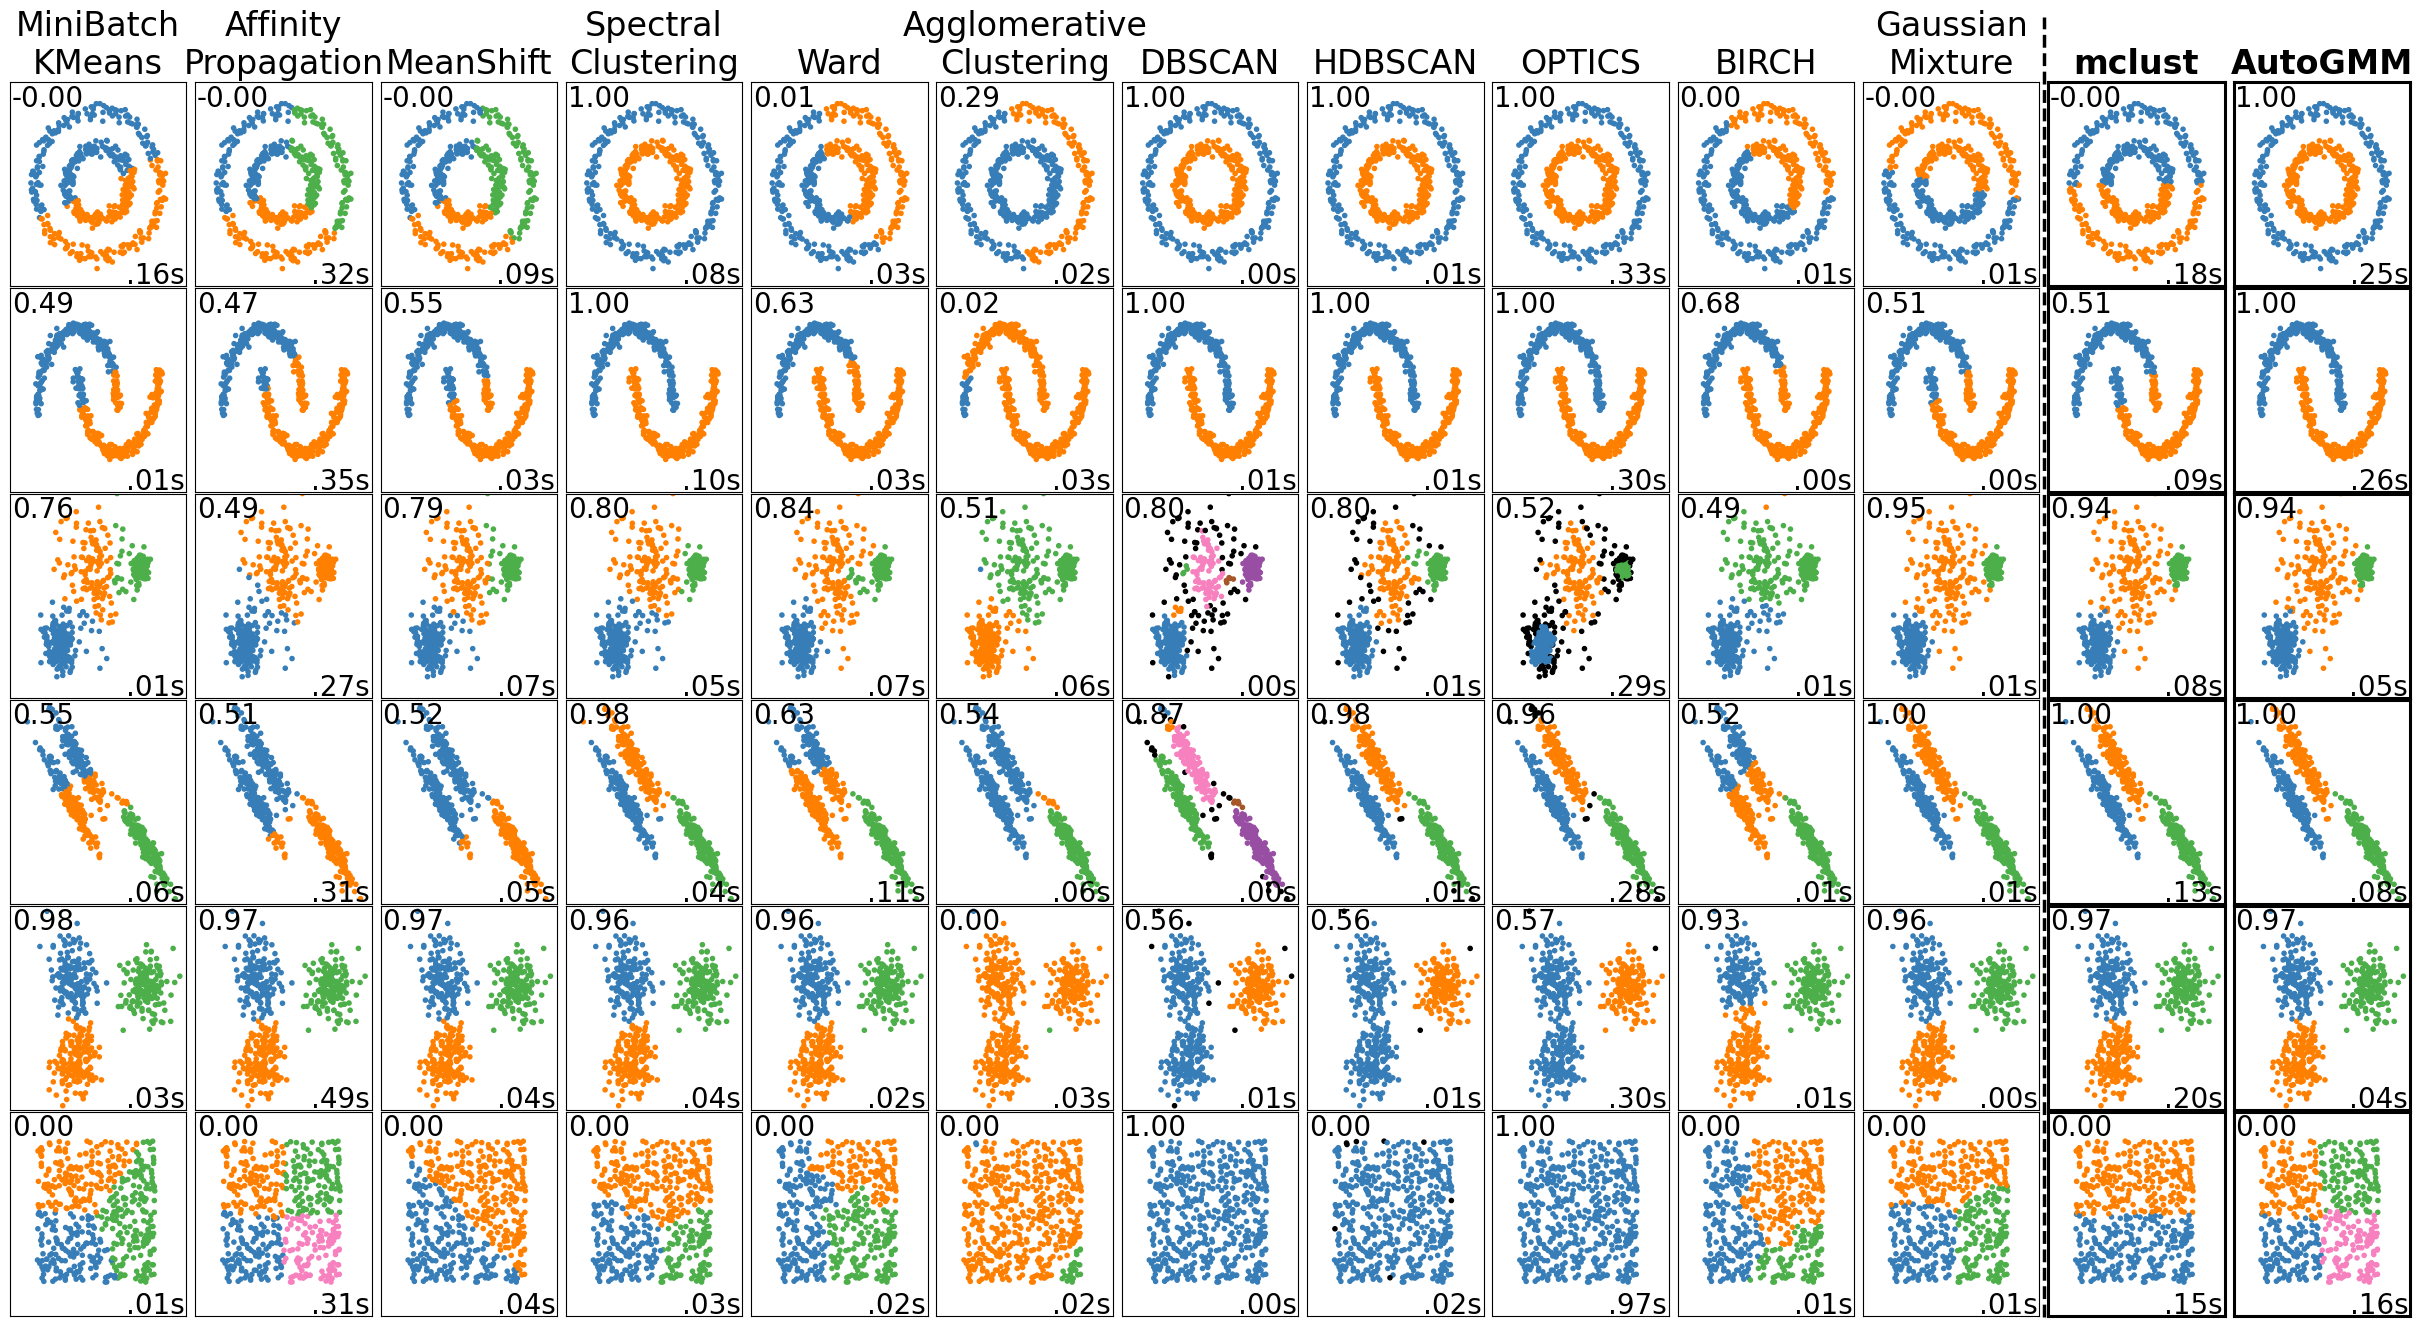

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn import cluster, datasets, mixture

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(11 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
    "kernel": False,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
            "kernel": True,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
            "kernel": True,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )
    if i_dataset != len(datasets) - 1:
        agmm = KernelAutoGMM(
            min_components=params["n_clusters"],
            max_components=params["n_clusters"],
            n_init_kmeans=0,
            eigen_thres=True,
            kernel_embedding=params["kernel"],
            random_state=params["random_state"],
            agglom_affinities=["mahalanobis"],
            agglom_linkages=["ward"],
            n_jobs=1,
        )
    else:
        agmm = KernelAutoGMM(
            min_components=1,
            max_components=5,
            n_init_kmeans=0,
            eigen_thres=True,
            kernel_embedding=params["kernel"],
            random_state=params["random_state"],
            agglom_affinities=["mahalanobis"],
            agglom_linkages=["ward"],
            n_jobs=1,
        )
    mc = params["n_clusters"]
    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
        ("mclust", mc),
        ("AutoGMM", agmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            if name != "mclust":
                algorithm.fit(X)
                t1 = time.time()

        if name == "mclust":
            if i_dataset != len(datasets) - 1:
                y_pred, _, _, _ = run_mclust(X, constrain_cov=False, n_components=mc)
                t1 = time.time()
            else:
                y_pred, _, _, _ = run_mclust(
                    X, constrain_cov=False, n_components=range(1, 3)
                )
                t1 = time.time()
            y_pred = y_pred - 1
        else:
            if hasattr(algorithm, "labels_"):
                y_pred = algorithm.labels_.astype(int)
            else:
                y_pred = algorithm.predict(X)
        if y is None:
            y = np.zeros(len(X))
        ari = adjusted_rand_score(y, y_pred)
        # sort cluster labels by their centroid (x then y); keep -1 (noise) as last
        labels = np.unique(y_pred)
        nonnoise = labels[labels != -1]
        centroids = np.array([X[y_pred == lbl].mean(axis=0) for lbl in nonnoise])
        order = np.lexsort((centroids[:, 1], centroids[:, 0]))  # sort by x, then y
        ordered = nonnoise[order]
        remap = {lbl: i for i, lbl in enumerate(ordered)}
        y_pred_ordered = np.array(
            [remap.get(lbl, len(ordered)) for lbl in y_pred], dtype=int
        )

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=24)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            # "#984ea3", '#00B8D9', '#FF8F00', '#8D6E63','#00C853',
                            # '#00897B',  "#999999","#e41a1c", "#dede00"]),
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=9, color=colors[y_pred_ordered])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=20,
            horizontalalignment="right",
        )
        plt.text(
            0.01,
            0.99,
            f"{ari:.2f}",
            transform=plt.gca().transAxes,
            size=20,
            horizontalalignment="left",
            va="top",
        )
        plot_num += 1


fig = plt.gcf()
axes = fig.axes
# find which column index is the "Gaussian Mixture" plot
gm_idx = next(
    i
    for i, (name, _) in enumerate(clustering_algorithms)
    if name.replace("\n", "") == "GaussianMixture"
)

# grab the axes positions in figure‐coords
pos_gm = axes[gm_idx].get_position()  # right edge of GaussianMixture
pos_agmm = axes[gm_idx + 1].get_position()  # left edge of AutoGMM

# place line midway between them
x = 0.5 * (pos_gm.x1 + pos_agmm.x0)

divider = Line2D(
    [x, x],
    [0, 1],  # span bottom→top in fig coords
    transform=fig.transFigure,
    color="k",
    linestyle="--",
    linewidth=2.5,
    clip_on=False,
)
fig.add_artist(divider)

# --- highlight the right-most algorithms (e.g., 'mclust' and 'AutoGMM') ---
highlight_names = ["mclust", "AutoGMM"]  # <- change if your last columns differ

cols = len(clustering_algorithms)
rows = len(datasets)
name_to_col = {
    nm.replace("\n", ""): i for i, (nm, _) in enumerate(clustering_algorithms)
}
cols_to_highlight = [name_to_col[n] for n in highlight_names]

# subtle tint + thicker colored border for every row in those columns
for r in range(rows):
    for c in cols_to_highlight:
        axh = axes[r * cols + c]
        # axh.set_facecolor("#fff7e6")  # light warm tint
        for sp in axh.spines.values():
            sp.set_linewidth(2.2)
            # sp.set_color("#984ea3")    # accent color

# make the top-row titles bold and colored (and add a star)
for c in cols_to_highlight:
    axt = axes[c]  # row 0 in column c
    axt.set_title(axt.get_title(), size=24, fontweight="bold")


plt.show()

In [4]:
def aniso_plus(seed, rep_id):
    np.random.seed(seed + rep_id)
    cov_1 = 1
    cov_2 = 50
    n = 50  # 100
    mu_ = 3
    mu1 = [-mu_, 0]
    mu2 = [mu_, 0]
    cov1 = np.array([[cov_1, 0], [0, cov_2]])
    cov2 = np.array([[cov_1, 0], [0, cov_2]])
    X1 = np.random.multivariate_normal(mu1, cov1, n)
    X2 = np.random.multivariate_normal(mu2, cov2, n)
    X = np.concatenate((X1, X2))
    y = np.repeat([0, 1], int(len(X) / 2))

    return X, y

In [ ]:
def aniso_plus_hd(
    seed: int,
    rep_id: int,
    d: int = 10,
    n_per: int = 150,
    mu: float = 3.0,
    cov_small: float = 1.0,
    cov_large: float = 50.0,
    fill_var: float = 1.0,
    rotate: bool = True,
    align_mean: str = "small",  # 'small'/'large' eigen-direction
    # (only if delta_sd is used)
    delta_sd: float | None = None,
):
    """
    High-dimensional two-component Gaussian data with anisotropy.

    Parameters
    ----------
    seed : int
        Base random seed.
    rep_id : int
        Replicate index (added to seed for reproducibility across reps).
    d : int, default=50
        Ambient dimensionality.
    n_per : int, default=50
        Samples per class (total n = 2 * n_per).
    mu : float, default=3.0
        Half-distance between class means along the first coordinate when
        delta_sd is None (matches your original 2D behavior).
    cov_small : float, default=1.0
        Small variance (eigenvalue) used to define anisotropy.
    cov_large : float, default=50.0
        Large variance (eigenvalue) used to define anisotropy.
    fill_var : float, default=1.0
        Variance for the remaining (d-2) directions.
    rotate : bool, default=False
        If True, apply a random orthonormal rotation so the covariance is not
        axis-aligned. Rotation preserves eigenvalues (anisotropy)
        but changes orientation.
    align_mean : {'small','large'}, default='small'
        Which eigen-direction to use for class separation when delta_sd is not None.
    delta_sd : float or None, default=None
        If provided, set the class means to be ±(delta_sd/2) standard deviations
        along the chosen eigen-direction (in the rotated basis if rotate=True).
        If None, use axis-aligned means at ±mu on the first coordinate.

    Returns
    -------
    X : (2*n_per, d) ndarray
        Feature matrix.
    y : (2*n_per,) ndarray
        Labels in {0,1}.
    Sigma : (d, d) ndarray
        Shared covariance used to generate both classes.

    Notes
    -----
    - The anisotropy level (condition number) of the covariance is approximately
      cond = cov_large / min(cov_small, fill_var)
      if cov_large is the largest eigenvalue.
    - rotate=True does not change anisotropy, only its orientation.
    """
    rng = np.random.default_rng(seed + rep_id)

    # Eigenvalues: two special directions + (d-2) filler
    eigs = np.concatenate(([cov_small, cov_large], np.full(max(d - 2, 0), fill_var)))

    # Random orthonormal basis if requested
    if rotate:
        Q, _ = np.linalg.qr(rng.standard_normal((d, d)))
        if np.linalg.det(Q) < 0:  # ensure proper rotation
            Q[:, 0] *= -1
    else:
        Q = np.eye(d)

    # Shared covariance Sigma = Q diag(eigs) Q^T
    Sigma = (Q * eigs) @ Q.T

    # Means
    if delta_sd is None:
        # Match your original: separation on coordinate 0 by ±mu
        mu1 = np.zeros(d)
        mu1[0] = -mu
        mu2 = np.zeros(d)
        mu2[0] = mu
    else:
        # Separate along chosen eigen-direction by delta_sd standard deviations
        idx_small = int(np.argmin(eigs))
        idx_large = int(np.argmax(eigs))
        idx = idx_small if align_mean == "small" else idx_large
        v = Q[:, idx] / np.linalg.norm(Q[:, idx])
        offset = 0.5 * delta_sd * np.sqrt(eigs[idx]) * v
        mu1 = -offset
        mu2 = offset

    # Sample
    X1 = rng.multivariate_normal(mu1, Sigma, size=n_per)
    X2 = rng.multivariate_normal(mu2, Sigma, size=n_per)
    X = np.vstack([X1, X2])
    y = np.repeat([0, 1], n_per)

    return X, y

In [ ]:
def one_rep(seed, rep_id):
    X, y = aniso_plus_hd(seed, rep_id)
    # k = len(np.unique(y))
    k1 = 1
    k2 = 5

    pred = AutoGMM(
        min_components=k1,
        max_components=k2,
        random_state=seed + rep_id,
        n_init_kmeans=0,
        agglom_affinities=["mahalanobis"],
        agglom_linkages=["ward"],
    ).fit_predict(X)
    ari_mw = adjusted_rand_score(y, pred)

    pred = AutoGMM(
        min_components=k1,
        max_components=k2,
        random_state=seed + rep_id,
        n_init_kmeans=0,
        agglom_affinities=["euclidean"],
        agglom_linkages=["ward"],
    ).fit_predict(X)
    ari_ew = adjusted_rand_score(y, pred)

    pred = AutoGMM(
        min_components=k1,
        max_components=k2,
        random_state=seed + rep_id,
        n_init_kmeans=1,
        agglom_linkages=["ward"],
    ).fit_predict(X)
    ari_agmm = adjusted_rand_score(y, pred)

    return ari_ew, ari_mw, ari_agmm

In [ ]:
# number of repetitions
n_reps = 50
seed = 0

results = Parallel(n_jobs=-1)(
    delayed(one_rep)(seed, rep_id) for rep_id in tqdm(range(n_reps))
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


In [ ]:
updated_results = []
for rep_id, (ari1, ari2, ari3) in enumerate(results):
    X, y = aniso_plus_hd(seed, rep_id)
    k = len(np.unique(y))
    _, _, _, _, ari4 = run_mclust(
        X=pd.DataFrame(X), n_components=range(1, 5), y_true=y, constrain_cov=False
    )
    updated_results.append((ari1, ari2, ari3, ari4))

In [ ]:
ari1, ari2, ari3, ari4 = zip(*updated_results)
df = pd.DataFrame(
    {
        "ARI": np.concatenate([ari1, ari2, ari3, ari4]),
        "Method": (
            ["AutoGMM\n(Euc-Ward only)"] * len(ari1)
            + ["AutoGMM\n(Mah-Ward only)"] * len(ari2)
            + ["AutoGMM\n(Full)"] * len(ari3)
            + ["mclust"] * len(ari4)
        ),
    }
)
colors = ["#FA8072", "#B22222", "#8B0000", "#808000"]

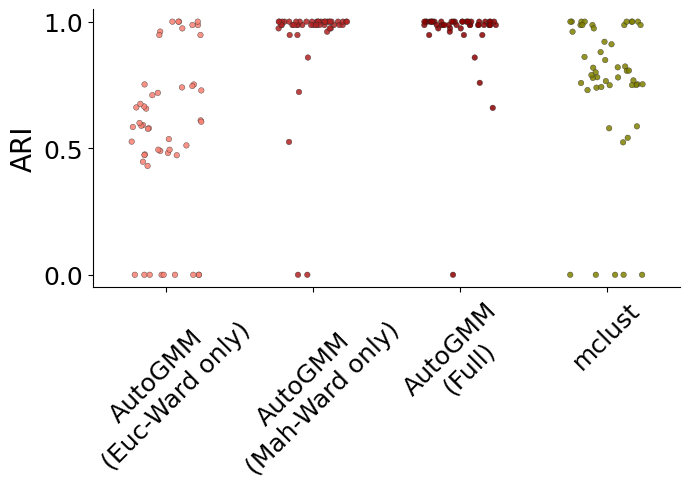

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(len(colors) + 3, 5))


sns.stripplot(
    data=df,
    x="Method",
    y="ARI",
    hue="Method",  # color by method (same as x)
    palette=colors,
    dodge=False,  # don't split since hue==x
    jitter=0.25,  # add jitter
    size=4,
    alpha=0.85,
    linewidth=0.3,
    ax=ax,
)
sns.despine(ax=ax, top=True, right=True)
# Compute mean ARI per method
means = df.groupby("Method")["ARI"].mean()

# Get the plotted category labels in order
labels = [tick.get_text() for tick in ax.get_xticklabels()]


# plt.title('Extreme Variation', fontsize=17)
plt.ylabel("ARI", fontsize=20)
plt.xlabel("")
plt.xticks(rotation=45, ha="center", fontsize=18)
plt.yticks([0, 0.5, 1], fontsize=18)
# plt.grid()
plt.tight_layout()
plt.show()

In [12]:
def generate_data(random_state, expand_dim=1, n_samples=500):
    # Anisotropicly distributed data
    X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=3)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)

    if expand_dim > 1:
        for idx in range(expand_dim - 1):
            X_, _ = make_blobs(n_samples=n_samples, random_state=idx * random_state)
            X_aniso_ = np.dot(X_, transformation)
            X_aniso = np.concatenate((X_aniso, X_aniso_), axis=1)
    aniso = (X_aniso, y)

    return [aniso]

In [13]:
def one_rep(expand_dim, seed, rep_id, k1=None, k2=None):
    datasets = generate_data(seed + rep_id, expand_dim)
    aris = []
    for data in datasets:
        X, y = data
        ari = []
        if k1:
            k1_ = k1
            k2_ = k2

        else:
            k1_ = len(np.unique(y))
            k2_ = k1_

        pred = AutoGMM(
            min_components=k1_,
            max_components=k2_,
            n_init_kmeans=1,
            agglom_affinities=["euclidean", "mahalanobis"],
            random_state=seed + rep_id,
        ).fit_predict(X)
        ari.append(adjusted_rand_score(y, pred))

        aris.append(ari)

    return aris

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm

n_reps = 50
seed = 0
dims = range(1, 11)
k1 = 1
k2 = 5

all_results = []

for dim_ in tqdm(dims):
    results = Parallel(n_jobs=-1)(
        delayed(one_rep)(dim_, seed, rep_id, k1, k2) for rep_id in tqdm(range(n_reps))
    )

    updated_results = []
    for rep_id, aris_per_dataset in enumerate(results):
        mclust_arised = []
        datasets = generate_data(seed + rep_id, expand_dim=dim_)
        for dataset_aris, (X, y) in zip(aris_per_dataset, datasets):
            k = len(np.unique(y))
            if k1:
                _, _, _, _, ari_mclust_all = run_mclust(
                    X=pd.DataFrame(X),
                    constrain_cov=False,
                    y_true=y,
                    n_components=range(k1, k2 + 1),
                )
            else:
                _, _, _, _, ari_mclust_all = run_mclust(
                    X=pd.DataFrame(X), constrain_cov=False, y_true=y, n_components=k
                )
            updated = dataset_aris + [ari_mclust_all]
            mclust_arised.append(updated)
        updated_results.append(mclust_arised)

    all_results.append(updated_results)

100%|██████████| 10/10 [03:31<00:00, 21.17s/it]


In [ ]:
def results_to_long_df(all_results, dims, method_names=None, dataset_names=None):
    """
    all_results[dim_idx][rep_idx][dataset_idx][method_idx] -> ARI
    -> DataFrame with columns: Dim, Rep, Dataset, Method, ARI
    """
    first_dim = all_results[0]
    n_datasets = len(first_dim[0])
    # n_methods = len(first_dim[0][0])

    if method_names is None:
        method_names = ["AutoGMM\n(Full)", "mclust"]
    if dataset_names is None:
        dataset_names = [f"Dataset {i}" for i in range(n_datasets)]

    rows = []
    for dim_val, dim_block in zip(dims, all_results):
        for rep_idx, rep_block in enumerate(dim_block):
            for ds_idx, methods_list in enumerate(rep_block):
                for m_idx, ari in enumerate(methods_list):
                    rows.append(
                        {
                            "Dim": int(dim_val),
                            "Rep": int(rep_idx),
                            "Dataset": dataset_names[ds_idx],
                            "Method": method_names[m_idx],
                            "ARI": float(ari),
                        }
                    )
    return pd.DataFrame(rows)


# ---- Build df_long ----
df_long = results_to_long_df(all_results, dims, method_names=None, dataset_names=None)

dims_even = sorted(df_long["Dim"].unique())
df_long["Dim"] = pd.Categorical(df_long["Dim"], categories=dims_even, ordered=True)
df_long["Dim_num"] = df_long["Dim"].astype(int) * 2

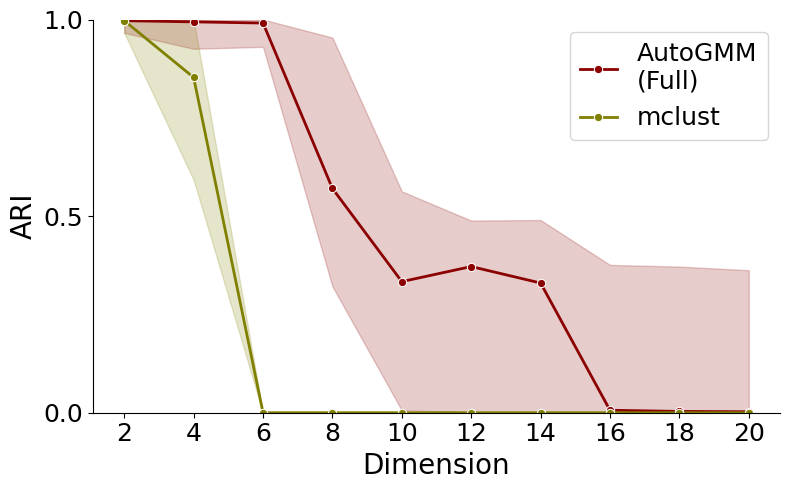

In [ ]:
plt.figure(figsize=(8, 5))
colors = ["#8B0000", "#808000"]

ax = sns.lineplot(
    data=df_long,
    x="Dim_num",
    y="ARI",
    hue="Method",
    palette=colors,
    estimator=np.median,
    errorbar=("pi", 50),
    marker="o",
    linewidth=2,
)

sns.despine(ax=ax, top=True, right=True)
plt.ylabel("ARI", fontsize=20)
plt.xticks(rotation=0, ha="center", fontsize=18)
plt.yticks([0, 0.5, 1], fontsize=18)

ax.set_ylim(0, 1)
ax.set_xlabel("Dimension", fontsize=20)
ax.set_xticks(np.array(dims_even) * 2)
ax.legend(title=None, ncol=1, fontsize=18, handlelength=1.5, columnspacing=0.8)
plt.tight_layout()
plt.show()

In [ ]:
n_list = [100, 500, 1000, 5000, 10000]
d_list = [2, 5, 10, 20, 50]
n_jobs_list = [1, 4]

methods = [
    ("AutoGMM", "#8B0000"),
    ("mclust", "#808000"),
]

markers = {1: "-", 4: "--", 8: ":"}


def time_and_labels(name, X, nj=None):
    if name == "GaussianMixture":
        model = GaussianMixture(n_components=3, random_state=1)
        start = time.perf_counter()
        model.fit(X)
        return time.perf_counter() - start
    elif name == "AutoGMM":
        model = AutoGMM(
            min_components=3,
            max_components=3,
            n_jobs=nj,
            agglom_affinities=["mahalanobis", "euclidean"],
            agglom_linkages=["ward"],
            eigen_thres=True,
            n_init_kmeans=1,
            random_state=1,
        )
        start = time.perf_counter()
        model.fit(X)
        return time.perf_counter() - start
    else:  # mclust
        _, runtime, _, _ = run_mclust(
            X=pd.DataFrame(X), n_components=range(3, 4), constrain_cov=False
        )
        return runtime


# Storage for results
all_results = []
n_reps = 10
for idx in range(n_reps):
    results = {"runtime_n": {}, "runtime_d": {}}

    # Compute runtime and ARI vs n (fixed d=10)
    name = "AutoGMM"
    for nj in n_jobs_list:
        times = []
        for n in tqdm(n_list):
            X, y = make_blobs(n_samples=n, n_features=10, centers=3, random_state=idx)
            t = time_and_labels(name, X, nj)
            times.append(t)
        results["runtime_n"][(name, nj)] = (times, "#8B0000", markers[nj])

    for name, color in methods:
        times = []
        for n in tqdm(n_list):
            X, y = make_blobs(n_samples=n, n_features=10, centers=3, random_state=idx)
            t = time_and_labels(name, X)
            times.append(t)
        results["runtime_n"][(name, 1)] = (times, color, markers[1])

    # Compute runtime and ARI vs d (fixed n=1000)
    name = "AutoGMM"
    for nj in n_jobs_list:
        times = []
        for d in tqdm(d_list):
            X, y = make_blobs(n_samples=1000, n_features=d, centers=3, random_state=idx)
            t = time_and_labels(name, X, nj)
            times.append(t)
        results["runtime_d"][(name, nj)] = (times, "#8B0000", markers[nj])

    for name, color in methods:
        times = []
        for d in d_list:
            X, y = make_blobs(n_samples=1000, n_features=d, centers=3, random_state=idx)
            t = time_and_labels(name, X)
            times.append(t)
        results["runtime_d"][(name, 1)] = (times, color, markers[1])

    all_results.append(results)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


In [ ]:
agg = {"runtime_n": {}, "runtime_d": {}}

for metric in ["runtime_n", "runtime_d"]:
    # get the set of all (method,nj) keys
    keys = all_results[0][metric].keys()
    for key in keys:
        if key[1] > 1:
            continue
        # collect a 2D array: shape (n_reps, len(x_axis))
        data = np.vstack(
            [
                rep[metric][key][0]  # the times or aris list from each rep
                for rep in all_results
            ]
        )
        mean = data.mean(axis=0)
        std = data.std(axis=0, ddof=1)
        color, marker = all_results[0][metric][key][1:]
        agg[metric][key] = (mean, std, color, marker)

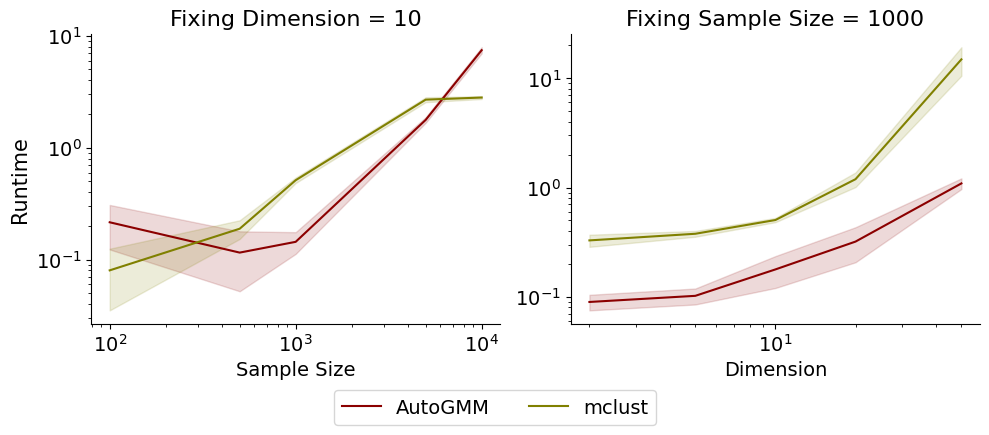

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes_map = {"runtime_n": axes[0], "runtime_d": axes[1]}

for metric, ax in axes_map.items():
    x = n_list if "_n" in metric else d_list
    for (method, nj), (mean, std, color, marker) in agg[metric].items():
        if nj > 4:
            continue
        label = f"{method} ({nj} job)" if nj == 1 else f"{method} ({nj} jobs)"
        ax.plot(x, mean, label=label, color=color, linestyle=marker)
        ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.15)
    if metric.startswith("runtime"):  # runtime_n, runtime_d
        ax.set_xscale("log")
        ax.set_yscale("log")
    else:  # ari_n, ari_d
        ax.set_xscale("log")
    ax.set_title(metric)
    ax.set_xlabel("Sample Size" if "_n" in metric else "Dimension", fontsize=14)
    if ax == axes[0]:
        ax.set_title("Fixing Dimension = 10", fontsize=16)
        ax.set_ylabel("Runtime", fontsize=15)
    elif ax == axes[1]:
        ax.set_ylabel("")
        ax.set_title("Fixing Sample Size = 1000", fontsize=16)
for ax in axes.flat:
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.tick_params(axis="both", which="minor", labelsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# grab handles & labels from one of the axes
handles, labels = axes[1].get_legend_handles_labels()
labels[1] = "mclust"
labels[0] = "AutoGMM"

# create a single legend below all subplots
fig.legend(
    handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=14
)

# make room at the bottom
fig.tight_layout()
fig.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

### real data

In [ ]:
from graspologic.embed import AdjacencySpectralEmbed
from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata

##### drosophila connectome data

In [ ]:
droso_embed = np.genfromtxt(
    "examples/data/real/embedded_right.csv", delimiter=",", skip_header=1
)
droso_df = pd.read_csv("examples/data/real/embedded_right.csv")
droso_true = np.genfromtxt("examples/data/real/classes.csv", skip_header=1)
print(droso_embed.shape)

(213, 6)


In [26]:
X = droso_embed.copy()
# Compute squared Euclidean distance matrix
distance_matrix = squareform(pdist(X, metric="sqeuclidean"))

In [27]:
# Perform Adjacency Spectral Embedding
# for drosophila
ase_ = AdjacencySpectralEmbed(n_elbows=3)
ase_transform = ase_.fit_transform(distance_matrix)

loadings = ase_.latent_left_
ase_transform.shape[1]

5

In [28]:
k1_, k2_ = 1, 5

y = droso_true.copy()

agmm = AutoGMM(
    min_components=k1_,
    max_components=k2_,
    agglom_linkages=["ward"],
    agglom_affinities=["mahalanobis"],
    random_state=0,
    n_jobs=-1,
)
pred_agmm = agmm.fit_predict(X)
print(adjusted_rand_score(y, pred_agmm), len(np.unique(pred_agmm)))

pred_mc, _, _, _, ari_ = run_mclust(
    X, n_components=range(k1_, k2_ + 1), constrain_cov=False, y_true=y
)
print(ari_, len(np.unique(pred_mc)))

0.7625124246223806 4
0.623750897642111 5


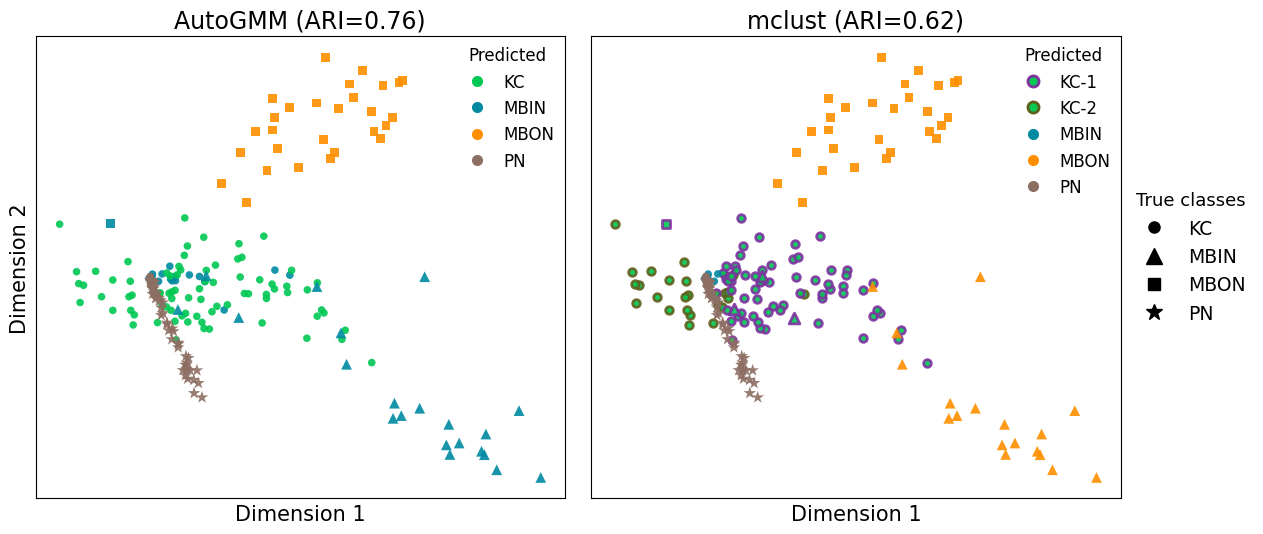

In [ ]:
import matplotlib.lines as mlines
from scipy.optimize import linear_sum_assignment


# --- helpers ---------------------------------------------------------------
def contingency(y_ref, y_pred):
    ur = np.unique(y_ref)
    up = np.unique(y_pred)
    C = np.zeros((ur.size, up.size), dtype=int)
    for i, r in enumerate(ur):
        mr = y_ref == r
        for j, p in enumerate(up):
            C[i, j] = np.sum(mr & (y_pred == p))
    return C, ur, up


def permute_to_ref(y_pred, y_ref):
    # unconstrained (1–1 if k_pred==k_true)
    C, ur, up = contingency(y_ref, y_pred)
    r_ind, c_ind = linear_sum_assignment(C.max() - C)
    mapping = {
        up[j]: ur[i] for i, j in zip(r_ind, c_ind) if i < len(ur) and j < len(up)
    }
    # leftover preds (if any) -> majority ref
    for lp in up:
        if lp not in mapping:
            j = np.where(up == lp)[0][0]
            mapping[lp] = ur[np.argmax(C[:, j])]
    y_map = np.array([mapping[label] for label in y_pred])
    return y_map, mapping


def permute_with_single_split(y_pred, y_ref):
    """
    Force exactly one true class to receive two predicted clusters
    (when k_pred = k_true + 1).
    Chooses the split class that maximizes total overlap.
    Returns: y_mapped, mapping (pred->true), split_info=(true_label, [pred1, pred2])
    """
    C, ur, up = contingency(y_ref, y_pred)
    R, S = C.shape
    assert S == R + 1, "This helper expects exactly one extra predicted cluster."
    best = None
    for r in range(R):  # try splitting true class ur[r]
        A = np.vstack([C, C[r]])  # duplicate row r -> (R+1) x S
        row_labels = list(ur) + [ur[r]]  # last row is the duplicate
        ri, cj = linear_sum_assignment(A.max() - A)
        score = A[ri, cj].sum()
        if best is None or score > best[0]:
            # collect which pred columns map to the duplicated class
            split_preds = [
                up[cj[k]] for k, i in enumerate(ri) if row_labels[i] == ur[r]
            ]
            best = (score, ri, cj, row_labels, ur[r], split_preds)
    _, ri, cj, row_labels, split_true, split_preds = best
    mapping = {up[j]: row_labels[i] for i, j in zip(ri, cj)}
    y_map = np.array([mapping[label] for label in y_pred])
    return y_map, mapping, (split_true, split_preds)


# --- counts ---
def true_counts(y_true):
    return {t: int(np.sum(y_true == t)) for t in np.unique(y_true)}


def pred_counts(y_pred_raw):
    up, cnt = np.unique(y_pred_raw, return_counts=True)
    return {int(p): int(c) for p, c in zip(up, cnt)}


# --- data / alignment -------------------------------------------------------
Z2 = ase_transform[:, 3:5]
y_true = np.asarray(y)
y_ag_raw = np.asarray(pred_agmm)
y_mc_raw = np.asarray(pred_mc)

# AutoGMM: standard mapping (1–1)
y_ag_map, map_ag = permute_to_ref(y_ag_raw, y_true)

# mclust: force exactly one split
y_mc_map, map_mc, (split_true, split_preds) = permute_with_single_split(
    y_mc_raw, y_true
)

df = pd.DataFrame(
    {
        "ASE_1": Z2[:, 0],
        "ASE_2": Z2[:, 1],
        "true": y_true,
        "pred_agmm_raw": y_ag_raw,
        "pred_agmm": y_ag_map,
        "pred_mc_raw": y_mc_raw,
        "pred_mc": y_mc_map,
    }
)

# --- styling ---------------------------------------------------------------
true_ids = np.unique(y_true)
true_markers = {true_ids[0]: "o", true_ids[1]: "^", true_ids[2]: "s", true_ids[3]: "*"}
true_names = {
    true_ids[0]: "KC",
    true_ids[1]: "MBIN",
    true_ids[2]: "MBON",
    true_ids[3]: "PN",
}

palette = ["#00C853", "#008AA2", "#FF8F00", "#8D6E63"]
color_for = {t: palette[i % len(palette)] for i, t in enumerate(true_ids)}

# Build edge-style map for mclust: only the two split clusters get edges
mc_edge_for = {p: ("none", 0.0) for p in np.unique(y_mc_raw)}  # default: no edge
# Order the two split preds deterministically: larger overlap gets black edge
# (helps the eye but any order is fine)
C_true, ur, up = contingency(y_true, y_mc_raw)
row = np.where(ur == split_true)[0][0]
overlaps = {p: C_true[row, np.where(up == p)[0][0]] for p in split_preds}
split_order = sorted(split_preds, key=lambda q: overlaps[q], reverse=True)
edge_defs = [("#7F32A0", 2), ("#615F1C", 2)]
for p, (ec, lw) in zip(split_order, edge_defs):
    mc_edge_for[p] = (ec, lw)

# --- plotting ---------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.05)
panels = [
    ("AutoGMM (ARI=0.76)", "pred_agmm_raw", map_ag, None),  # None => no special edges
    ("mclust (ARI=0.62)", "pred_mc_raw", map_mc, mc_edge_for),
]

for ax, (title, raw_col, mapping, edge_map) in zip(axes, panels):
    for t in true_ids:  # shape = TRUE
        ms = {"o": 30, "*": 90, "s": 40}.get(true_markers[t], 60)
        for p in np.unique(df[raw_col]):  # iterate predicted clusters
            sub = df[(df["true"] == t) & (df[raw_col] == p)]
            if sub.empty:
                continue
            face = color_for[mapping[p]]  # color by mapped TRUE class
            if edge_map is None:
                ec, lw = ("none", 0.0)  # AutoGMM: no edges anywhere
            else:
                ec, lw = edge_map.get(
                    p, ("none", 0.0)
                )  # mclust: only split preds get edges
            ax.scatter(
                sub["ASE_1"],
                sub["ASE_2"],
                c=[face],
                marker=true_markers[t],
                s=ms,
                alpha=0.9,
                edgecolors=ec,
                linewidth=lw,
                zorder=2,
            )
    ax.set_title(title, fontsize=17)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Dimension 1", fontsize=15)
    if title.startswith("AutoGMM"):
        ax.set_ylabel("Dimension 2", fontsize=15)

# --- legends ---------------------------------------------------------------
# figure-level (truth shapes)
counts_true = true_counts(y_true)
true_handles = [
    mlines.Line2D(
        [],
        [],
        color="black",
        marker=true_markers[t],
        linestyle="None",
        markersize=(12 if true_markers[t] in {"^", "*"} else 8),
        #   label=true_names[t]
    )
    for t in true_ids
]
true_labels = [f"{true_names[t]}" for t in true_ids]  # (n={counts_true[t]})
fig.legend(
    true_handles,
    #    [true_names[t] for t in true_ids],
    true_labels,
    frameon=False,
    loc="upper center",
    ncol=1,
    bbox_to_anchor=(0.95, 0.65),
    title="True classes",
    fontsize=13.5,
    title_fontsize=13,
)


# panel-specific predicted legends:
def predicted_legend_single_split(
    ax, mapping, split_true, split_preds, counts_pred, color_for, true_names, title
):
    # all non-split classes: single entry; split class: two entries with edges
    from collections import defaultdict

    inv = defaultdict(list)
    for pred_label, t in mapping.items():
        inv[t].append(pred_label)
    handles, labels = [], []
    for t in sorted(inv, key=lambda x: true_names[x]):
        if t != split_true:
            p = inv[t][0]
            h = mlines.Line2D(
                [],
                [],
                linestyle="None",
                marker="o",
                markersize=8,
                markerfacecolor=color_for[t],
                markeredgecolor="none",
            )
            handles.append(h)
            labels.append(f"{true_names[t]}")  # (n={counts_pred[p]})
        else:
            # ensure deterministic order (same as plot)
            for i, p in enumerate(split_order, 1):
                ec, lw = mc_edge_for[p]
                h = mlines.Line2D(
                    [],
                    [],
                    linestyle="None",
                    marker="o",
                    markersize=8,
                    markerfacecolor=color_for[t],
                    markeredgecolor=ec,
                    markeredgewidth=lw,
                )
                handles.append(h)
                labels.append(f"{true_names[t]}-{i}")  # (n={counts_pred[p]})
    ax.legend(
        handles,
        labels,
        ncol=1,
        loc="upper right",
        bbox_to_anchor=(1, 1),
        title=title,
        fontsize=12,
        title_fontsize=12,
        frameon=False,
        borderaxespad=0.2,
        handletextpad=0.6,
        columnspacing=1.0,
    )


# build counts for each method
counts_ag_pred = pred_counts(y_ag_raw)
counts_mc_pred = pred_counts(y_mc_raw)

# AutoGMM: 4 entries; mclust: 5 entries with exactly one split
predicted_legend_single_split(
    axes[0], map_ag, None, [], counts_ag_pred, color_for, true_names, "Predicted"
)
predicted_legend_single_split(
    axes[1],
    map_mc,
    split_true,
    split_preds,
    counts_mc_pred,
    color_for,
    true_names,
    "Predicted",
)

plt.show()

##### fragmentomics data

In [ ]:
frag_df = pd.read_csv("examples/data/real/fragmentomics.csv")

frag_df = frag_df[frag_df["Cohort"] != 1]
frag_pc = frag_df.loc[:, frag_df.columns.str.startswith("PC")].to_numpy()
frag_label = frag_df["Cohort"].values
print(frag_pc.shape, frag_label.shape)

(466, 12) (466,)


In [31]:
X = frag_pc.copy()

# Compute squared Euclidean distance matrix
distance_matrix = squareform(pdist(X, metric="sqeuclidean"))
ranked_distance_matrix = rankdata(distance_matrix, axis=None).reshape(
    distance_matrix.shape
)

In [32]:
# Perform Adjacency Spectral Embedding

# for fragmentomics
ase_ = AdjacencySpectralEmbed(n_elbows=2)
ase_transform = ase_.fit_transform(ranked_distance_matrix)

loadings = ase_.latent_left_
ase_transform.shape[1]

3

In [33]:
k1_, k2_ = 1, 5
y = frag_label.copy()

agmm = AutoGMM(
    min_components=k1_,
    max_components=k2_,
    agglom_linkages=["ward"],
    agglom_affinities=["mahalanobis"],
    random_state=0,
    n_jobs=-1,
)
pred_agmm = agmm.fit_predict(X)
print(adjusted_rand_score(y, pred_agmm), len(np.unique(pred_agmm)))

pred_mc, _, _, _, ari_ = run_mclust(
    X, n_components=range(k1_, k2_ + 1), constrain_cov=False, y_true=y
)
print(ari_, len(np.unique(pred_mc)))

0.2985659297817876 4
0.24705710438153186 3


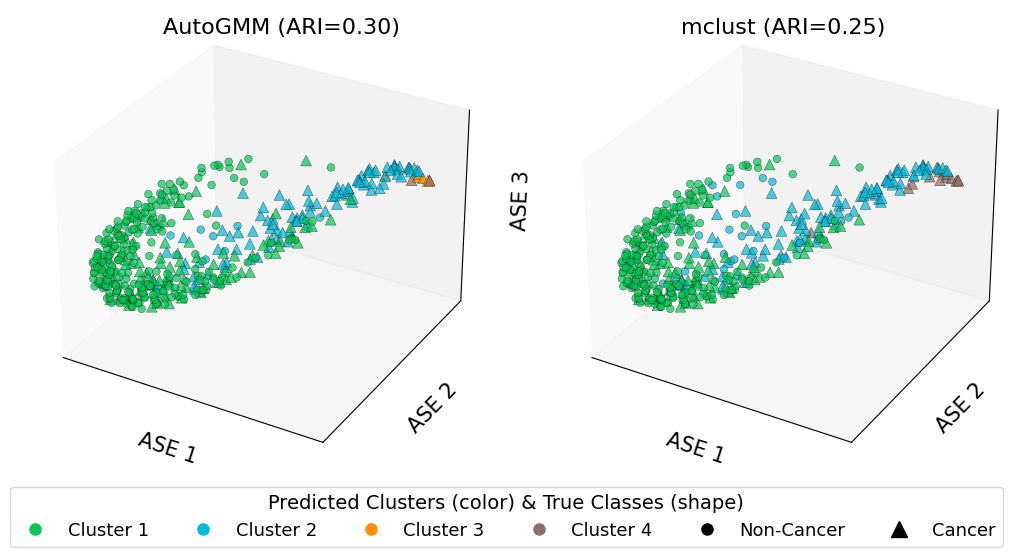

In [ ]:
import matplotlib.lines as mlines

df = pd.DataFrame(
    {
        "ASE_1": ase_transform[:, 0],
        "ASE_2": ase_transform[:, 1],
        "ASE_3": ase_transform[:, 2],
        "pred_agmm": np.where(
            pred_agmm == 2, 1, np.where(pred_agmm == 1, 2, pred_agmm)
        ),
        "pred_mc": np.where(pred_mc == 2, 0, np.where(pred_mc == 0, 2, pred_mc)),
        "true": y,
    }
)

clusters = df["pred_agmm"].value_counts().index.to_numpy()
# cluster_to_idx = {int(cl): i for i, cl in enumerate(clusters)}
cluster_to_idx = {int(i): i for i, cl in enumerate(clusters)}

true_classes = range(len(np.unique(df["true"])) + 1)
colors = ["#00C853", "#00B8D9", "#FF8F00", "#8D6E63", "#00897B"]

markers = {true_classes[0]: "o", true_classes[2]: "^", true_classes[1]: "s"}

fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": "3d"})
plt.subplots_adjust(wspace=-0.05)
label_cols = ["pred_agmm", "pred_mc"]
titles = ["AutoGMM (ARI=0.30)", "mclust (ARI=0.25)"]

for ax, label_col, _title in zip(axes, label_cols, titles):
    for t in true_classes:
        for c in clusters:
            sub = df[(df["true"] == t) & (df[label_col] == c)]
            if sub.empty:
                continue
            # enlarge triangle markers
            size = 30 if markers[t] != "^" else 60
            ax.scatter(
                sub["ASE_1"],
                sub["ASE_2"],
                sub["ASE_3"],
                c=colors[cluster_to_idx[int(c)] % len(colors)],
                marker=markers[t],
                s=size,
                alpha=0.7,
                edgecolor="k",
                linewidth=0.3,
            )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel("ASE 1", fontsize=15)
    ax.set_ylabel("ASE 2", fontsize=15)
    ax.set_zlabel("ASE 3", fontsize=15)

cluster_handles = [
    mlines.Line2D(
        [],
        [],
        color=colors[cluster_to_idx[int(c)] % len(colors)],
        marker="o",
        linestyle="None",
        markersize=8,
        label=f"Cluster {c+1}",
    )
    for c in clusters
]
true_classes_names = ["Non-Cancer", "Cancer"]
markers = ["o", "^"]
true_handles = [
    mlines.Line2D(
        [],
        [],
        color="k",
        marker=markers[i],
        linestyle="None",
        markersize=8 if markers[t] == "o" else 12,
        label=f"{true_classes_names[i]}",
    )
    for i, t in enumerate(true_classes[:-1])
]
fig.text(0.255, 0.84, "AutoGMM (ARI=0.30)", fontsize=16)
fig.text(0.625, 0.84, "mclust (ARI=0.25)", fontsize=16)
fig.legend(
    handles=cluster_handles + true_handles,
    loc="upper center",
    ncol=8,
    bbox_to_anchor=[0.5, 0.1],
    title="Predicted Clusters (color) & True Classes (shape)",
    fontsize=13,
    title_fontsize=14,
)

plt.show()